<a href="https://colab.research.google.com/github/lsteffenel/M2Atmo_et_Climat/blob/main/14-TCN_pluiedemain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Un classifieur TCN pour prédire le temps de demain
Dans cet exercice, nous allons utiliser les modèles encodeur-décodeur et TCN en tant que classifieur.

En effet, l'objectif est simple : à partir d'une liste de données pour l'Australie en 2015, nous allons déterminer si demain on aura l'une des deux situations suivantes :
- pluie
- pas de pluie

Pour cela, on considère la définition météorologique de pluie, i.e., "un taux de précipitation supérieur à 1mm"

Tout d'abord, téléchargéons les données et lisons-les avec Pandas.

In [17]:
!wget https://github.com/lsteffenel/M2Atmo_et_Climat/raw/refs/heads/main/data/weatherAUS_until_2016_01_01.csv
!wget https://github.com/lsteffenel/M2Atmo_et_Climat/raw/refs/heads/main/data/weatherAUS_complete.csv

--2024-11-24 18:37:20--  https://github.com/lsteffenel/M2Atmo_et_Climat/raw/refs/heads/main/data/weatherAUS_until_2016_01_01.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lsteffenel/M2Atmo_et_Climat/refs/heads/main/data/weatherAUS_until_2016_01_01.csv [following]
--2024-11-24 18:37:21--  https://raw.githubusercontent.com/lsteffenel/M2Atmo_et_Climat/refs/heads/main/data/weatherAUS_until_2016_01_01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10742625 (10M) [text/plain]
Saving to: ‘weatherAUS_until_2016_01_01.csv’

weatherAUS_until_20 100%[===================>]  10.24M  --.-KB/s    in

In [18]:
import os
from datetime import datetime
import pandas as pd


def get_df_until_2016_01_01():
    df = pd.read_csv('/content/weatherAUS_until_2016_01_01.csv',
        date_parser = lambda d: datetime.strptime(d, '%Y-%m-%d'),
        index_col = 'Date',
        sep=';'
    )
    return df


def get_df_complete():
    df = pd.read_csv('/content/weatherAUS_complete.csv',
        date_parser = lambda d: datetime.strptime(d, '%Y-%m-%d'),
        index_col = 'Date',
        sep=';'
    )
    return df

Ces fichiers contiennent plusieurs variables différentes, comme vous pouvez constater ici :

In [24]:
df = get_df_until_2016_01_01()
df.head(5)

<ipython-input-18-14c2148a67e1>:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/weatherAUS_until_2016_01_01.csv',


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,"13,4","22,9","0,6",NaN,NaN,W,44.0,W,WNW,...,24.0,71.0,22.0,"1007,7","1007,1",8.0,NaN,"16,9","21,8",No
2008-12-02,Albury,"7,4","25,1",0,NaN,NaN,WNW,44.0,NNW,WSW,...,22.0,44.0,25.0,"1010,6","1007,8",NaN,NaN,"17,2","24,3",No
2008-12-03,Albury,"12,9","25,7",0,NaN,NaN,WSW,46.0,W,WSW,...,26.0,38.0,30.0,"1007,6","1008,7",NaN,2.0,21,"23,2",No
2008-12-04,Albury,"9,2",28,0,NaN,NaN,NE,24.0,SE,E,...,9.0,45.0,16.0,"1017,6","1012,8",NaN,NaN,"18,1","26,5",No
2008-12-05,Albury,"17,5","32,3",1,NaN,NaN,W,41.0,ENE,NW,...,20.0,82.0,33.0,"1010,8",1006,7.0,8.0,"17,8","29,7",No


In [25]:
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

Comme nous pouvons observer ci-dessous, on a un dataset avec une bonne quantité de données. Les graphiques montrent les valeurs de précipitation, ainsi que les labels "rain today" attribués à des dates entre janvier 2015 et janvier 2016 à Sydney.

<ipython-input-18-14c2148a67e1>:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/weatherAUS_until_2016_01_01.csv',


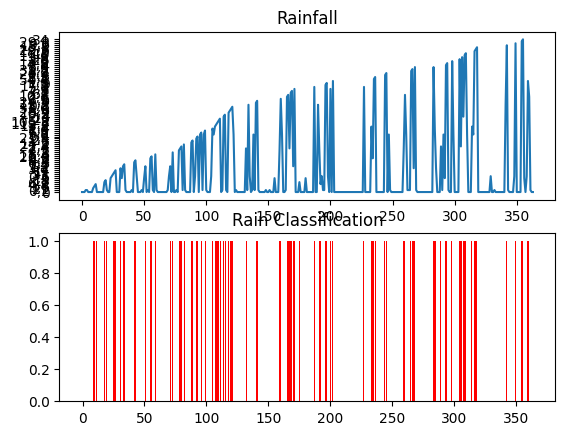

In [22]:
import matplotlib.pyplot as plt


df_syd = df[(df['Location'] == 'Sydney') &
            (df.index > '2015-01-01')]

rainfall = df_syd['Rainfall'].values
raintoday = df_syd['RainToday']\
    .map({'Yes': 1, 'No': 0}).values

fig, axs = plt.subplots(2)
axs[0].set_title('Rainfall')
axs[0].plot(rainfall)
axs[1].set_title('Rain Classification')
axs[1].bar(range(len(raintoday)), raintoday, color = 'red')
plt.show()


Etant donné que la distribution de la pluie n'a pas un pattern évident, on essayera de créer une prédiction de la classe "pluie" ou "pas pluie" à partir de plusieurs variables (*multivariate input single-step classification*).

Seulement un certain nombre de variables seront utilisées, afin de prédire 'RainToday' :

'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am','Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'


# Un modèle TCN

À la fin de l'exercice précédent on a utilisé un modèle TCN pour faire une prédiction du nombre de cas COVID19. Ici, un TCN sera utilisé pour la classification :

In [ ]:
import torch
from typing import OrderedDict

import torch.nn as nn
from torch.nn.utils import weight_norm


class Crop(nn.Module):

    def __init__(self, crop_size):
        super(Crop, self).__init__()
        self.crop_size = crop_size

    def forward(self, x):
        return x[:, :, :-self.crop_size].contiguous()


class TemporalCasualLayer(nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 kernel_size,
                 stride,
                 dilation,
                 dropout = 0.2,
                 act = 'relu',
                 slices = 2,
                 use_bias = True
                 ):
        super(TemporalCasualLayer, self).__init__()
        padding = (kernel_size - 1) * dilation
        conv_params = {
            'kernel_size': kernel_size,
            'stride':      stride,
            'padding':     padding,
            'dilation':    dilation
        }
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh()
        }

        self.use_bias = use_bias

        layers = OrderedDict()
        for s in range(1, slices + 1):
            if s == 1:
                layers[f'conv{s}'] = weight_norm(nn.Conv1d(n_inputs, n_outputs, **conv_params))
            else:
                layers[f'conv{s}'] = weight_norm(nn.Conv1d(n_outputs, n_outputs, **conv_params))
            layers[f'crop{s}'] = Crop(padding)
            layers[f'act{s}'] = activations[act]
            layers[f'dropout{s}'] = nn.Dropout(dropout)

        self.net = nn.Sequential(layers)

        if n_inputs != n_outputs and use_bias:
            self.bias = nn.Conv1d(n_inputs, n_outputs, 1)
        else:
            self.bias = None

        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.net(x)
        if self.use_bias:
            b = x if self.bias is None else self.bias(x)
            return self.relu(y + b)
        else:
            return self.relu(y)


class TemporalConvolutionNetwork(nn.Module):

    def __init__(self,
                 num_inputs,
                 num_channels,
                 kernel_size = 2,
                 dropout = 0.2,
                 slices = 2,
                 act = 'relu',
                 use_bias = True
                 ):
        super(TemporalConvolutionNetwork, self).__init__()
        layers = []
        num_levels = len(num_channels)

        tcl_param = {
            'kernel_size': kernel_size,
            'stride':      1,
            'dropout':     dropout,
            'slices':      slices,
            'act':         act,
            'use_bias':    use_bias
        }

        for i in range(num_levels):
            dilation = 2**i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            tcl_param['dilation'] = dilation
            tcl = TemporalCasualLayer(in_ch, out_ch, **tcl_param)
            layers.append(tcl)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TcnClassifier(nn.Module):

    def __init__(self, **params):
        super(TcnClassifier, self).__init__()
        self.num_channels = params['num_channels']
        self.num_classes = params.pop('num_classes')

        self.tcn = TemporalConvolutionNetwork(**params)
        self.linear = nn.Linear(self.num_channels[-1], self.num_classes)

    def forward(self, x):
        x = self.tcn(x)
        x = self.linear(x[:, :, -1])
        y = torch.log_softmax(x, dim = 1)
        return y

On fera un premier modèle avec une partie des données (janvier 2020 à janvier 2021), et quelques pays seulement.

In [ ]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

df = get_df_until_2021_02_01()
start_date = '2020-01-01'
end_date = '2021-02-01'
countries = ['Italy', 'Russia', 'Hungary', 'Austria', 'Israel', 'Poland']

# size of the sliding window
w = 120
# length of prediction
out = 60
# number of training epochs
epochs = 200

# Initializing the model
params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1,
    'lr':             .01,
    'tfr':            .1
}

# Hyper-parameters:
hidden_size = params['hidden_size']
hidden_dl_size = params['hidden_dl_size']
lr = params['lr']
tfr = params['tfr']



#formater les données

avant de lancer l'entraînement, il faut également formater les données en tant que "séries temporelles", i.e., créer des fenêtres de données (X jours de mesures pour Y jours de cible). On fait également le nettoyage des données, s'il y a des valeurs manquantes.

In [ ]:
import statsmodels.api as sm

# Preparing Sliding-window Datasets
X, Y = [], []
for c in countries:
    # diff
    ts_df = df[df['Country'] == c]['Confirmed'].diff().dropna()
    train = ts_df[start_date:end_date].values
    # Normalized time series
    train = train / max(train)
    # Statistical pre-processing
    _, train_hp_trend = sm.tsa.filters.hpfilter(train)
    train_cf_cycle, _ = sm.tsa.filters.cffilter(train)

    D = []
    for i in range(len(train)):
        D.append([train[i], train_hp_trend[i], train_cf_cycle[i]])

    # input - output for country
    X_c, Y_c = sliding_window(D, w, out)
    X.extend(X_c)
    Y.extend(Y_c)

# Train-Validation Split
X_train, Y_train = [], []
X_val, Y_val = [], []
for i in range(len(X)):
    if random.random() > .8:
        X_val.append(X[i])
        Y_val.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

# Converting datasets to tensors
x_train = torch.tensor(X_train).float().transpose(0, 1)
y_train = torch.tensor(Y_train).float().transpose(0, 1)[:, :, 0]
x_val = torch.tensor(X_val).float().transpose(0, 1)
y_val = torch.tensor(Y_val).float().transpose(0, 1)[:, :, 0]



Enfin, l'entraînement 💪

Ici on afiche les résultats à chaque 10 époques d'entraînement (c'est assez rapide, avec un GPU)

In [ ]:
model_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model = EncoderDecoder(**model_params)
model.train()

# Training and getting the results
model_params, val = model.train_model(
        x_train, y_train, x_val, y_val, epochs, out,
        method = 'mixed_teacher_forcing', tfr = tfr, lr = lr)

Et pour tester le modèle, on essaye de prédire la tendance en Autriche entre février et avril 2021 (regardez la date de fin)

In [ ]:
from datetime import datetime
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model.eval()
from_date = '2020-10-04'
to_date = '2021-04-01'
date_fmt = '%Y-%m-%d'
country = 'Austria'
df = get_df_complete()
au_ts_df = df[df['Country'] == country]['Confirmed'].diff().dropna()
ts = au_ts_df[from_date:to_date].values
test = ts[:120]
max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

x = torch.tensor([X]).float().transpose(0, 1)
model.eval()
predicted = model.predict(x, 60)

in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
target_seq = list(ts[120:])
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.strptime(from_date, date_fmt)
end_date = start_date + dt.timedelta(days = len(in_seq))
prediction_date = start_date + dt.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))

plt.title(f'Prediction for next 60 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + target_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'Model prediction',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()


# La même chose, mais avec un modèle TCN

Nous allons reprendre le même dataset, mais avec un modèle TCN cette fois-ci.

In [ ]:
import torch
from typing import OrderedDict

import torch.nn as nn
from torch.nn.utils import weight_norm


class Crop(nn.Module):

    def __init__(self, crop_size):
        super(Crop, self).__init__()
        self.crop_size = crop_size

    def forward(self, x):
        return x[:, :, :-self.crop_size].contiguous()


class TemporalCasualLayer(nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 kernel_size,
                 stride,
                 dilation,
                 dropout = 0.2,
                 act = 'relu',
                 slices = 2,
                 use_bias = True
                 ):
        super(TemporalCasualLayer, self).__init__()
        padding = (kernel_size - 1) * dilation
        conv_params = {
            'kernel_size': kernel_size,
            'stride':      stride,
            'padding':     padding,
            'dilation':    dilation
        }
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh()
        }

        self.use_bias = use_bias

        layers = OrderedDict()
        for s in range(1, slices + 1):
            if s == 1:
                layers[f'conv{s}'] = weight_norm(nn.Conv1d(n_inputs, n_outputs, **conv_params))
            else:
                layers[f'conv{s}'] = weight_norm(nn.Conv1d(n_outputs, n_outputs, **conv_params))
            layers[f'crop{s}'] = Crop(padding)
            layers[f'act{s}'] = activations[act]
            layers[f'dropout{s}'] = nn.Dropout(dropout)

        self.net = nn.Sequential(layers)

        if n_inputs != n_outputs and use_bias:
            self.bias = nn.Conv1d(n_inputs, n_outputs, 1)
        else:
            self.bias = None

        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.net(x)
        if self.use_bias:
            b = x if self.bias is None else self.bias(x)
            return self.relu(y + b)
        else:
            return self.relu(y)


class TemporalConvolutionNetwork(nn.Module):

    def __init__(self,
                 num_inputs,
                 num_channels,
                 kernel_size = 2,
                 dropout = 0.2,
                 slices = 2,
                 act = 'relu',
                 use_bias = True
                 ):
        super(TemporalConvolutionNetwork, self).__init__()
        layers = []
        num_levels = len(num_channels)

        tcl_param = {
            'kernel_size': kernel_size,
            'stride':      1,
            'dropout':     dropout,
            'slices':      slices,
            'act':         act,
            'use_bias':    use_bias
        }

        for i in range(num_levels):
            dilation = 2**i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            tcl_param['dilation'] = dilation
            tcl = TemporalCasualLayer(in_ch, out_ch, **tcl_param)
            layers.append(tcl)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TcnClassifier(nn.Module):

    def __init__(self, **params):
        super(TcnClassifier, self).__init__()
        self.num_channels = params['num_channels']
        self.num_classes = params.pop('num_classes')

        self.tcn = TemporalConvolutionNetwork(**params)
        self.linear = nn.Linear(self.num_channels[-1], self.num_classes)

    def forward(self, x):
        x = self.tcn(x)
        x = self.linear(x[:, :, -1])
        y = torch.log_softmax(x, dim = 1)
        return y


In [ ]:
model2_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model2 = EncoderDecoder(**model2_params)
model2.train()

# Training and getting the results
model2_params, val2 = model2.train_model(
        x_train, y_train, x_val, y_val, epochs, out,
       tfr = tfr, lr = lr)

L'évaluation est presque identique, juste on utilise "model2" à la place de "model" afin de garder les deux variantes en mémoire.

In [ ]:
from datetime import datetime
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model2.eval()
from_date = '2020-10-04'
to_date = '2021-04-01'
date_fmt = '%Y-%m-%d'
country = 'Austria'
df = get_df_complete()
au_ts_df = df[df['Country'] == country]['Confirmed'].diff().dropna()
ts = au_ts_df[from_date:to_date].values
test = ts[:120]
max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

x = torch.tensor([X]).float().transpose(0, 1)
model2.eval()
predicted = model2.predict(x, 60)

in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
target_seq = list(ts[120:])
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.strptime(from_date, date_fmt)
end_date = start_date + dt.timedelta(days = len(in_seq))
prediction_date = start_date + dt.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))

plt.title(f'Prediction for next 60 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + target_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'TCN Model prediction',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()


À votre avis, lequel des modèles (encodeur-décodeur ou TCN) prédit au mieux la tendance des cas COVID pour l'Autriche ?

#Challenge

l'entraînement a été fait avec des pays de l'Europe, et testé avec l'Autriche.

Est-ce que ce modèle présenterait une bonne performance pour la France, les Etats Unis ou l'Argentine ?

En fonction de vos observations, créer des modèles par continent.
